# Emotion analysis on emotion dataset

*The dataset is taken from: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from preprocessing import filter_and_extract_lemma
from preprocessing import enumerate_encode, one_hot_encode
from preprocessing import one_hot_to_enumerate
from tensorflow.data import Dataset

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Attention
from keras.layers import Dropout, Embedding, BatchNormalization
from keras.optimizers import Adam

### Preprocess the data

In [5]:
train = pd.read_csv('data/emotion_dataset/train.txt', sep=';', names=['Text', 'Emotion'])
validation = pd.read_csv('data/emotion_dataset/val.txt', sep=';', names=['Text', 'Emotion'])
test = pd.read_csv('data/emotion_dataset/test.txt', sep=';', names=['Text', 'Emotion'])

In [6]:
train['Text'] = train['Text'].apply(filter_and_extract_lemma, True)
validation['Text'] = validation['Text'].apply(filter_and_extract_lemma, True)
test['Text'] = test['Text'].apply(filter_and_extract_lemma, True)

In [7]:
tokenizer = TfidfVectorizer()
tokenizer.fit_transform(train['Text'])

<16000x11830 sparse matrix of type '<class 'numpy.float64'>'
	with 123796 stored elements in Compressed Sparse Row format>

In [8]:
x_train = tokenizer.transform(train['Text'])
x_val = tokenizer.transform(validation['Text'])
x_test = tokenizer.transform(test['Text'])

In [9]:
y_train = enumerate_encode(train['Emotion'])
y_val = enumerate_encode(validation['Emotion'])
y_test = enumerate_encode(test['Emotion'])

## Traditional Machine Learning methods

### K-Nearest Neighbours Classifier model

In [10]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       275
           1       0.78      0.74      0.76       224
           2       0.78      0.86      0.82       695
           3       0.70      0.54      0.61       159
           4       0.83      0.82      0.82       581
           5       0.69      0.41      0.51        66

    accuracy                           0.78      2000
   macro avg       0.75      0.69      0.71      2000
weighted avg       0.78      0.78      0.78      2000



### Random Forest Classifier model

In [11]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_predict = rf.predict(x_test)
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       275
           1       0.83      0.84      0.84       224
           2       0.85      0.92      0.88       695
           3       0.78      0.64      0.70       159
           4       0.92      0.91      0.91       581
           5       0.64      0.58      0.61        66

    accuracy                           0.86      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.86      0.86      0.86      2000



### Support Vector Machine Classifier

In [12]:
svc = SVC()
svc.fit(x_train, y_train)
y_predict = svc.predict(x_test)
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       275
           1       0.88      0.79      0.83       224
           2       0.81      0.95      0.88       695
           3       0.82      0.53      0.64       159
           4       0.88      0.90      0.89       581
           5       0.81      0.52      0.63        66

    accuracy                           0.85      2000
   macro avg       0.85      0.74      0.78      2000
weighted avg       0.85      0.85      0.84      2000



## Neural Networks

### Prepare the dataset

In [13]:
x_train = x_train.todense()
x_val = x_val.todense()
x_test = x_test.todense()

In [14]:
y_train = one_hot_encode(train['Emotion'])
y_val = one_hot_encode(validation['Emotion'])
y_test = one_hot_encode(test['Emotion'])

In [15]:
# Prepare the training dataset
train_dataset = Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

# Prepare the validation dataset
val_dataset = Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(32)

### Dense Neural Network model

In [94]:
dense = Sequential()
dense.add(Input(x_train.shape[1]))

dense.add(Dense(16, activation='relu'))
dense.add(Dropout(0.5))

dense.add(Dense(8, activation='relu'))
dense.add(BatchNormalization())

dense.add(Dense(16, activation='relu'))
dense.add(Dropout(0.5))

dense.add(Dense(y_train.shape[1], activation='softmax'))
dense.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 16)                189296    
                                                                 
 dropout_31 (Dropout)        (None, 16)                0         
                                                                 
 dense_47 (Dense)            (None, 8)                 136       
                                                                 
 batch_normalization (Batch  (None, 8)                 32        
 Normalization)                                                  
                                                                 
 dense_48 (Dense)            (None, 16)                144       
                                                                 
 dropout_32 (Dropout)        (None, 16)                0         
                                                     

In [95]:
dense.compile(loss=['categorical_crossentropy'], metrics=['accuracy'], optimizer=Adam(0.0001))

In [96]:
history = dense.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40
500/500 [==============================] - 4s 6ms/step - loss: 1.7731 - accuracy: 0.2418 - val_loss: 1.7351 - val_accuracy: 0.3040
Epoch 2/40
500/500 [==============================] - 3s 6ms/step - loss: 1.6946 - accuracy: 0.3138 - val_loss: 1.6468 - val_accuracy: 0.3770
Epoch 3/40
500/500 [==============================] - 3s 6ms/step - loss: 1.6216 - accuracy: 0.3576 - val_loss: 1.5464 - val_accuracy: 0.4625
Epoch 4/40
500/500 [==============================] - 3s 6ms/step - loss: 1.5388 - accuracy: 0.4158 - val_loss: 1.4322 - val_accuracy: 0.5445
Epoch 5/40
500/500 [==============================] - 3s 6ms/step - loss: 1.4389 - accuracy: 0.4818 - val_loss: 1.3003 - val_accuracy: 0.5965
Epoch 6/40
500/500 [==============================] - 3s 6ms/step - loss: 1.3454 - accuracy: 0.5408 - val_loss: 1.1810 - val_accuracy: 0.6435
Epoch 7/40
500/500 [==============================] - 3s 6ms/step - loss: 1.2474 - accuracy: 0.5863 - val_loss: 1.0555 - val_accuracy: 0.6775
Epoch 

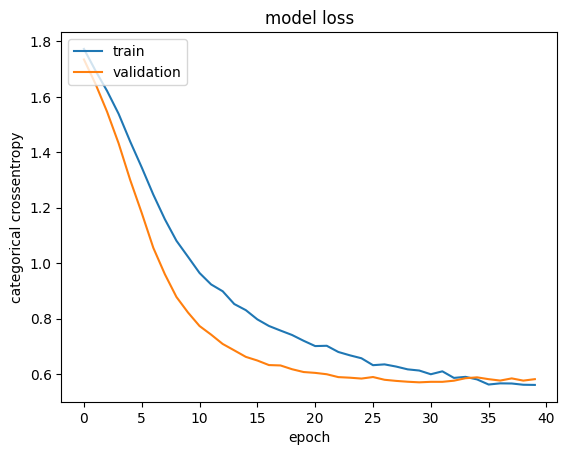

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [98]:
y_predict = dense.predict(x_test)
# convert encodings to make the classification report
y_predict = one_hot_to_enumerate(y_predict)
y_expected = one_hot_to_enumerate(y_test)

63/63 [==============================] - 0s 2ms/step


In [99]:
report = classification_report(y_expected, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       275
           1       0.76      0.82      0.79       224
           2       0.85      0.89      0.87       695
           3       0.61      0.59      0.60       159
           4       0.86      0.91      0.88       581
           5       0.75      0.05      0.09        66

    accuracy                           0.82      2000
   macro avg       0.78      0.68      0.68      2000
weighted avg       0.82      0.82      0.81      2000

